In [1]:
# ============ Imports ============
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [5]:
# ============ Configuration ============
# Seed for reproducibility
SEED_CONSTANT = 27
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

# Dataset path and parameters
DATASET_PATH = "C:/Users/ROG/OneDrive/Desktop/Projects/Sem 6 AI/UCF50"
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]


In [9]:
# Update CLASSES_LIST with folder names in the UCF50 directory
CLASSES_LIST = [folder_name for folder_name in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder_name))]
print("Updated CLASSES_LIST:", CLASSES_LIST)

Updated CLASSES_LIST: ['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [13]:
def frames_extraction(video_path):
    """Extract and preprocess frames from video."""
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [14]:
# List all class names and their sizes
class_sizes = {}
for class_name in CLASSES_LIST:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        class_sizes[class_name] = len(os.listdir(class_path))

print("Class Sizes:")
for class_name, size in class_sizes.items():
    print(f"{class_name}: {size}")

Class Sizes:
BaseballPitch: 150
Basketball: 137
BenchPress: 160
Biking: 145
Billiards: 150
BreastStroke: 101
CleanAndJerk: 112
Diving: 153
Drumming: 161
Fencing: 111
GolfSwing: 142
HighJump: 123
HorseRace: 127
HorseRiding: 197
HulaHoop: 125
JavelinThrow: 117
JugglingBalls: 122
JumpingJack: 123
JumpRope: 148
Kayaking: 157
Lunges: 141
MilitaryParade: 127
Mixing: 141
Nunchucks: 150
PizzaTossing: 114
PlayingGuitar: 160
PlayingPiano: 105
PlayingTabla: 124
PlayingViolin: 100
PoleVault: 160
PommelHorse: 123
PullUps: 120
Punch: 160
PushUps: 106
RockClimbingIndoor: 148
RopeClimbing: 130
Rowing: 137
SalsaSpin: 133
SkateBoarding: 120
Skiing: 144
Skijet: 100
SoccerJuggling: 156
Swing: 137
TaiChi: 100
TennisSwing: 167
ThrowDiscus: 131
TrampolineJumping: 119
VolleyballSpiking: 116
WalkingWithDog: 123
YoYo: 128


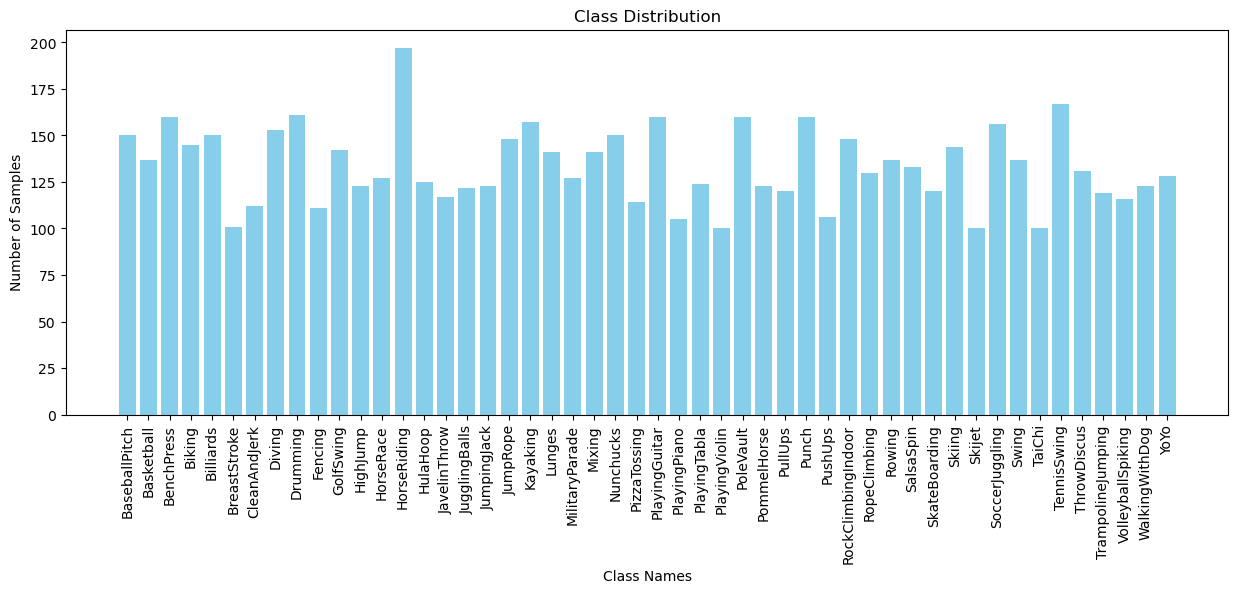

In [15]:
# Plotting the class sizes to identify imbalance
plt.figure(figsize=(15, 5))
plt.bar(class_sizes.keys(), class_sizes.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Kayaking
Extracting Data of Class: Lunges
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Mixing
Extracting Data of Class: Nunchucks
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingPiano
Extractin

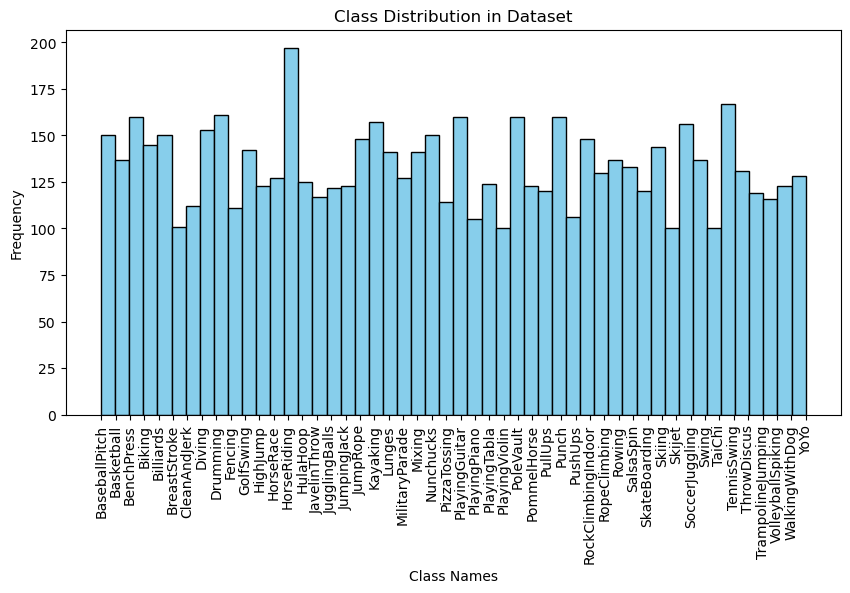

In [18]:
def create_dataset():
    """Create dataset from video files."""
    features, labels, video_files_paths = [], [], []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_PATH, class_name))
        for file_name in files_list:
            video_path = os.path.join(DATASET_PATH, class_name, file_name)
            frames = frames_extraction(video_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths


# Create the dataset
features, labels, video_files_paths = create_dataset()

# Display the numerical summary
print("Features Shape:", features.shape)
print("Labels Shape:", labels.shape)
print("Number of Video Files:", len(video_files_paths))

# Plot the distribution of labels
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(CLASSES_LIST), color='skyblue', edgecolor='black')
plt.xticks(ticks=range(len(CLASSES_LIST)), labels=CLASSES_LIST, rotation=90)
plt.xlabel('Class Names')
plt.ylabel('Frequency')
plt.title('Class Distribution in Dataset')
plt.show()


In [21]:
def create_convlstm_model():
    """Create ConvLSTM model architecture."""
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                         IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format="channels_last", recurrent_dropout=0.2,
                         return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    return model

# Define the model using the create_convlstm_model function
model = create_convlstm_model()

# Display the model summary
model.summary()


C:\Users\ROG\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │       1,800,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,804,562 (6.88 MB)

 Trainable params: 1,804,562 (6.88 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Load the dataset
features, labels, video_files_paths = create_dataset()
one_hot_encoded_labels = to_categorical(labels)

# Split into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=SEED_CONSTANT)


Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Biking
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: HulaHoop
Extracting Data of Class: JavelinThrow
Extracting Data of Class: JugglingBalls
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: Kayaking
Extracting Data of Class: Lunges
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Mixing
Extracting Data of Class: Nunchucks
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingPiano
Extractin

In [29]:

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Train the model
training_history = model.fit(x=features_train, y=labels_train, epochs=50,
                             batch_size=4, shuffle=True, validation_split=0.2,
                             callbacks=[early_stopping])



Epoch 1/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 110s 101ms/step - accuracy: 0.1660 - loss: 3.4347 - val_accuracy: 0.4711 - val_loss: 2.0874
Epoch 2/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 131s 90ms/step - accuracy: 0.5807 - loss: 1.6400 - val_accuracy: 0.5848 - val_loss: 1.6225
Epoch 3/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.7738 - loss: 0.8308 - val_accuracy: 0.6008 - val_loss: 1.7880
Epoch 4/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.8783 - loss: 0.4084 - val_accuracy: 0.6138 - val_loss: 2.0696
Epoch 5/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.9323 - loss: 0.2243 - val_accuracy: 0.5918 - val_loss: 2.4364
Epoch 6/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.9552 - loss: 0.1577 - val_accuracy: 0.6307 - val_loss: 2.0575
Epoch 7/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.9601 - loss: 0.1279 - val_accuracy: 0.6198 - val_loss: 2.4959
Epoch 8/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.968

In [ ]:
metric_value_1 = model_training_history.history[metric_name_1]
metric_value_2 = model_training_history.history[metric_name_2]
epochs = range(len(metric_value_1))

plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
plt.title(str(plot_name))
plt.legend()
plt.show()


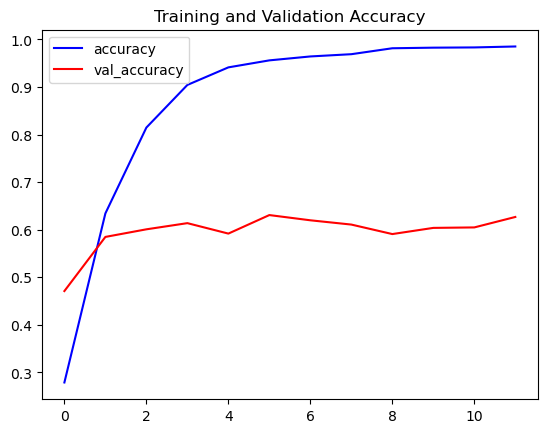

In [30]:
# Define metric names and plot title
metric_name_1 = 'accuracy'
metric_name_2 = 'val_accuracy'
plot_name = 'Training and Validation Accuracy'

# Extract metric values from training history
metric_value_1 = training_history.history[metric_name_1]
metric_value_2 = training_history.history[metric_name_2]
epochs = range(len(metric_value_1))

# Plot the metrics
plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
plt.title(plot_name)
plt.legend()
plt.show()